# Save yaml files for SIMCEO drivers

- AZ, EL, and GIR Controller
- Interface blocks to connect handle M1OFL control (mimicking the M1SA)

In [25]:
import numpy as np
import scipy.io as spio
#import scipy.linalg as la
from scipy import signal

import os
from os import path

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

import copy     # Enables deep copy
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

### Load IMS data file with controllers and interface parameters

In [19]:
# The files with controller and interface models are available from the GMT-IMS repository
filepath = '/Users/rromano/Workspace/GMT-IMS/'
# Control model file - Mount controllers retuned. 
filename = os.path.join(filepath,'controls_5pt3a_dev.mat')

gmt_Ts = spio.loadmat(filename)['fem']['Ts'][0][0][0][0]
print('Telescope structural dynamics sampling frequency:%gHz'%(1/gmt_Ts))

Telescope structural dynamics sampling frequency:1000Hz


### Mount controllers

In [20]:
mount_fbC = spio.loadmat(filename)['mount'][0]
print("Mount Ts:%0.3gs (%gHz)"%(mount_fbC[0][0],1/mount_fbC[0][0]))

# yaml filenames
az_yaml_file = 'AZ_fb_ssC.yaml'
el_yaml_file = 'EL_fb_ssC.yaml'
gir_yaml_file = 'GIR_fb_ssC.yaml'

Mount Ts:0.005s (200Hz)


#### Azimuth controller

In [21]:
az = mount_fbC[0][1][0][0]
az_fbC = az[0][0][0]
print('Controller dimensions:',
      '\nA:',az_fbC['A'].shape,
      '\nB:',az_fbC['B'].shape,
      '\nC:',az_fbC['C'].shape,
      '\nD:',az_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),-np.ones((1,4))/4))

az_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': az_fbC['A'].tolist(),
                               'B': (az_fbC['B'] @ Me).tolist(),
                               'C': az_fbC['C'].tolist(),
                               'D': (az_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast AZ controller yaml file
    with open(az_yaml_file,'w') as f:
        y.dump(az_fbC_dt, f)
    print('Mount AZ controller file saved as %s ' %az_yaml_file)

Controller dimensions: 
A: (11, 11) 
B: (11, 1) 
C: (1, 11) 
D: (1, 1)
Mount AZ controller file saved as AZ_fb_ssC.yaml 


#### Elevation controller

In [22]:
el = mount_fbC[0][2][0][0]
el_fbC = el[0][0][0]
print('Controller dimensions:',
      '\nA:',el_fbC['A'].shape,
      '\nB:',el_fbC['B'].shape,
      '\nC:',el_fbC['C'].shape,
      '\nD:',el_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),-np.ones((1,6))/6))

el_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': el_fbC['A'].tolist(),
                               'B': (el_fbC['B'] @ Me).tolist(),
                               'C': el_fbC['C'].tolist(),
                               'D': (el_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast EL controller yaml file
    with open(el_yaml_file,'w') as f:
        y.dump(el_fbC_dt, f)
    print('Mount EL controller file saved as %s ' %el_yaml_file)

Controller dimensions: 
A: (13, 13) 
B: (13, 1) 
C: (1, 13) 
D: (1, 1)
Mount EL controller file saved as EL_fb_ssC.yaml 


#### GIR controller

In [23]:
gir = mount_fbC[0][3][0][0]
gir_fbC = gir[0][0][0]
print('Controller dimensions:',
      '\nA:',gir_fbC['A'].shape,
      '\nB:',gir_fbC['B'].shape,
      '\nC:',gir_fbC['C'].shape,
      '\nD:',gir_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),-np.ones((1,4))/4))

gir_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': gir_fbC['A'].tolist(),
                               'B': (gir_fbC['B'] @ Me).tolist(),
                               'C': gir_fbC['C'].tolist(),
                               'D': (gir_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast GIR controller yaml file
    with open(gir_yaml_file,'w') as f:
        y.dump(gir_fbC_dt, f)
    print('Mount GIR controller file saved as %s ' %gir_yaml_file)

Controller dimensions: 
A: (8, 8) 
B: (8, 1) 
C: (1, 8) 
D: (1, 1)
Mount GIR controller file saved as GIR_fb_ssC.yaml 


Model files to combine `M1_Rel_F` with the wind load signals

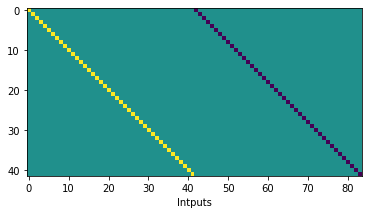


Files adder42_2.yaml and subtr42_2.yaml were created.


In [27]:
# D matrix to sum the inputs
ssD = np.hstack(( np.eye(42), np.eye(42) ))
adder42_2_dt = {'System' :
               {'sampling time': 0.001, #second ,
                'parameters': {'A': np.zeros((1, 1)).tolist(),
                               'B': np.zeros((1, 42+42)).tolist(),
                               'C': np.zeros((42, 1)).tolist(),
                               'D': ssD.tolist()}
               }}

subtr42_2_dt = copy.deepcopy(adder42_2_dt)
# D matrix to perform subtraction
ssD = np.hstack(( np.eye(42), -np.eye(42) ))
subtr42_2_dt['System']['parameters']['D'] = ssD.tolist()

filename1, filename2 = 'adder42_2.yaml', 'subtr42_2.yaml'

if True:
    # Save model files
    with open(filename1,'w') as f:
        y.dump(adder42_2_dt,f)   
    with open(filename2,'w') as f:
        y.dump(subtr42_2_dt,f)       
    print('\nFiles %s and %s were created.' %(filename1,filename2))
else:
    plt.imshow(subtr42_2_dt['System']['parameters']['D']), plt.xlabel('Intputs')
    plt.show()